In [191]:
import pandas as pd
import astroquery
import glob
from astropy.table import Table
import numpy as np
from astroquery.mast import Catalogs
import matplotlib.pyplot as plt
plt.style.use("seaborn-white")

# Cross reference with TESS Sectors

In [2]:
# Collect list of stellar parameter files
stellar_param_files = glob.glob("pydata/sumout_files/*")

In [3]:
# Generate Stellar Parameter DataFrame
stellar_param_dict = {}
files = ["pydata/sumout_files/11Com_2012.m.sumout"]
for file in stellar_param_files:
    with open(file,'r') as f:
        for i, line in enumerate(f):
            if i == 0:
                star = f.readline().split(" ")[0].split("_")[0] # fix this for ngc
                #print(star)
                params = [elem for elem in f.readline().split(" ") if elem != '']
                #print(params)
                metallicity = params[-2]
                if '-' in metallicity:
                    metallicity = metallicity[4:]
                file_dict = {'Teff': float(params[2]), 'Log_g':float(params[6]), 'M/H':float(metallicity)}
                #print(file_dict)
                stellar_param_dict[star] = file_dict
                
param_df = pd.DataFrame.from_dict(stellar_param_dict, orient='index')

In [68]:
stars = list(param_df.index)
print(stars)

param_df.loc[stars[0]]

['11Com', '18Del', '24Sex', '7CMa', '81Cet', 'AlphaAri', 'BD+12', 'BD+20274', 'GammaLeoA', 'HD100655', 'HD102272', 'HD102329', 'HD105096', 'HD108863', 'HD108991', 'HD115202', 'HD116029', 'HD118082', 'HD11977', 'HD121056', 'HD121156', 'HD123239', 'HD125217', 'HD126105', 'HD131496', 'HD1502', 'HD1690', 'HD17311', 'HD175541', 'HD176884', 'HD180902', 'HD181342', 'HD18742', 'HD188105', 'HD19138', 'HD192699', 'HD194937', 'HD19810', 'HD198599', 'HD200964', 'HD203638', 'HD205478', 'HD206610', 'HD20924', 'HD210702', 'HD212771', 'HD213066', 'HD21340', 'HD219553', 'HD233860', 'HD24148', 'HD24316', 'HD25069', 'HD28678', 'HD30128', 'HD30856', 'HD31693', 'HD31860', 'HD33142', 'HD33240', 'HD34909', 'HD39079', 'HD4313', 'HD45433', 'HD5319', 'HD58540', 'HD5877', 'HD5891', 'HD6037', 'HD64152', 'HD6665', 'HD68776', 'HD72292', 'HD73534', 'HD76321', 'HD84561', 'HD94386', 'HD95089', 'HD96036', 'HD96683', 'HD98219', 'HD98516', 'HD98579', 'HIP113622', 'HIP117756', 'Tyc0017-01084-1', 'Tyc0683-01190-1', 'Tyc120

Log_g       2.51
M/H        -0.28
Teff     4810.00
Name: 11Com, dtype: float64

### TESS Queries

In [86]:
# Example Query

target_name = "HD209458"
search_radius_deg = 0.05

catalogTIC = Catalogs.query_object(target_name, radius=search_radius_deg, catalog="TIC")
where_closest = np.argmin(catalogTIC['dstArcSec'])
print("Closest TIC ID to %s: TIC %s, separation of %f arcsec. and a TESS mag. of %f"%
      (target_name, catalogTIC['ID'][where_closest], catalogTIC['dstArcSec'][where_closest],
      catalogTIC['Tmag'][where_closest]))

#print(catalogTIC.colnames)
#print(catalogTIC['Teff'][where_closest])

Closest TIC ID to HD209458: TIC 420814525, separation of 0.173474 arcsec. and a TESS mag. of 7.105000


In [147]:
# Generate Comparison Dictionary

comp_dict = {}

search_radius_deg=0.05
for star in stars:
    target_name = star
    if target_name == "AlphaAri":
        target_name = "HD12929"
    elif target_name == "GammaLeoA":
        target_name = "HD89484"
    elif target_name == "xiAql":
        target_name = "HD188310"
        
    try:
        catalogTIC = Catalogs.query_object(target_name, radius=search_radius_deg, catalog="TIC")
        where_closest = np.argmin(catalogTIC['dstArcSec'])
        print("Closest TIC ID to %s: TIC %s, separation of %f arcsec. and a TESS mag. of %f"%
             (target_name, catalogTIC['ID'][where_closest], catalogTIC['dstArcSec'][where_closest],
              catalogTIC['Tmag'][where_closest]))
        if catalogTIC['dstArcSec'][where_closest] >= 0.4: # Ignore anything off by more than 0.4 arcseconds
            continue
        star_dict = {"TIC":catalogTIC['ID'][where_closest],
                     "meas_Teff": param_df.loc[star]["Teff"],
                     "meas_logg": param_df.loc[star]["Log_g"],
                     "meas_MH": param_df.loc[star]["M/H"],
                     "TESS_Teff": catalogTIC['Teff'][where_closest], 
                     "TESS_e_Teff": catalogTIC['e_Teff'][where_closest],
                     "TESS_logg": catalogTIC['logg'][where_closest],
                     "TESS_e_logg": catalogTIC['e_logg'][where_closest],
                     "TESS_MH": catalogTIC['MH'][where_closest],
                     "TESS_e_MH": catalogTIC['e_MH'][where_closest]}
        
        comp_dict[star] = star_dict
        
            
    except:
        print("No match found for {}".format(target_name))

comp_df = pd.DataFrame.from_dict(comp_dict, orient='index')
comp_df = comp_df[['TIC',"meas_Teff", "TESS_Teff", 'TESS_e_Teff',"meas_logg","TESS_logg","TESS_e_logg","meas_MH","TESS_MH", "TESS_e_MH"]]

Closest TIC ID to 11Com: TIC 72437047, separation of 0.246048 arcsec. and a TESS mag. of 3.824000
Closest TIC ID to 18Del: TIC 354489950, separation of 0.184347 arcsec. and a TESS mag. of 4.677000
Closest TIC ID to 24Sex: TIC 1713457, separation of 0.067388 arcsec. and a TESS mag. of 5.467000
Closest TIC ID to 7CMa: TIC 48237215, separation of 0.054738 arcsec. and a TESS mag. of 3.036000
Closest TIC ID to 81Cet: TIC 35725282, separation of 0.059964 arcsec. and a TESS mag. of 4.801000
Closest TIC ID to HD12929: TIC 306349516, separation of 0.346228 arcsec. and a TESS mag. of 0.793000
No match found for BD+12
Closest TIC ID to BD+20274: TIC 60923874, separation of 0.101842 arcsec. and a TESS mag. of 8.048000
Closest TIC ID to HD89484: TIC 471011652, separation of 0.123910 arcsec. and a TESS mag. of 2.010000
Closest TIC ID to HD100655: TIC 156942082, separation of 0.035694 arcsec. and a TESS mag. of 5.655000
Closest TIC ID to HD102272: TIC 82605074, separation of 0.142935 arcsec. and a TE

In [143]:
comp_df # Comparison Dictionary

,TIC,meas_Teff,TESS_Teff,TESS_e_Teff,meas_logg,TESS_logg,TESS_e_logg,meas_MH,TESS_MH,TESS_e_MH
11Com,72437047,4810.0,4742,--,2.51,2.31228,--,-0.28,--,--
18Del,354489950,5060.0,4979,--,3.09,2.94132,--,0.02,--,--
24Sex,1713457,5020.0,5098,--,3.40,3.24556,--,0.00,--,--
7CMa,48237215,4790.0,4792,--,3.21,3.89682,--,0.19,--,--
81Cet,35725282,4900.0,4785,--,2.89,2.73585,--,0.03,--,--
BD+20274,60923874,4360.0,4296,--,1.75,1.86543,--,-0.35,--,--
GammaLeoA,471011652,4430.0,--,--,1.81,--,--,-0.37,--,--
HD100655,156942082,4850.0,4861,--,2.78,2.88167,--,0.05,--,--
HD102272,82605074,4790.0,4908,--,2.54,2.70854,--,-0.36,--,--
HD102329,325254372,4780.0,4830,--,3.01,3.12978,--,0.08,--,--


In [196]:
# Get the subsets of comp_df that has TESS measurements and errors for the various stellar parameters

mask = [type(element) != np.ma.core.MaskedConstant for element in np.array(comp_df['TESS_e_Teff'])]
teff_df = comp_df[mask]

mask = [type(element) != np.ma.core.MaskedConstant for element in np.array(comp_df['TESS_e_logg'])]
logg_df = comp_df[mask]

# M/H has an entry with an uncertainty but no measurement so we need to double up on masks here
mask_e = [type(element) != np.ma.core.MaskedConstant for element in np.array(comp_df['TESS_e_MH'])]
mask_val = [type(element) != np.ma.core.MaskedConstant for element in np.array(comp_df['TESS_MH'])]
mask = np.array(mask_e) * np.array(mask_val)
MH_df = comp_df[mask]

print("Teff matches: {}".format(len(teff_df)),
      "logg matches: {}".format(len(logg_df)), 
      "M/H matches: {}".format(len(MH_df)))

print("Median Temperature Difference: {}".format(np.median(abs(teff_df['meas_Teff'] - teff_df['TESS_Teff']))))
print("Median Logg Difference: {}".format(np.median(abs(logg_df['meas_logg'] - logg_df['TESS_logg']))))
print("Median M/H Difference: {}".format(np.median(abs(MH_df['meas_MH'] - MH_df['TESS_MH']))))


Teff matches: 40 logg matches: 37 M/H matches: 21
Median Temperature Difference: 80.5
Median Logg Difference: 0.35792
Median M/H Difference: 0.09


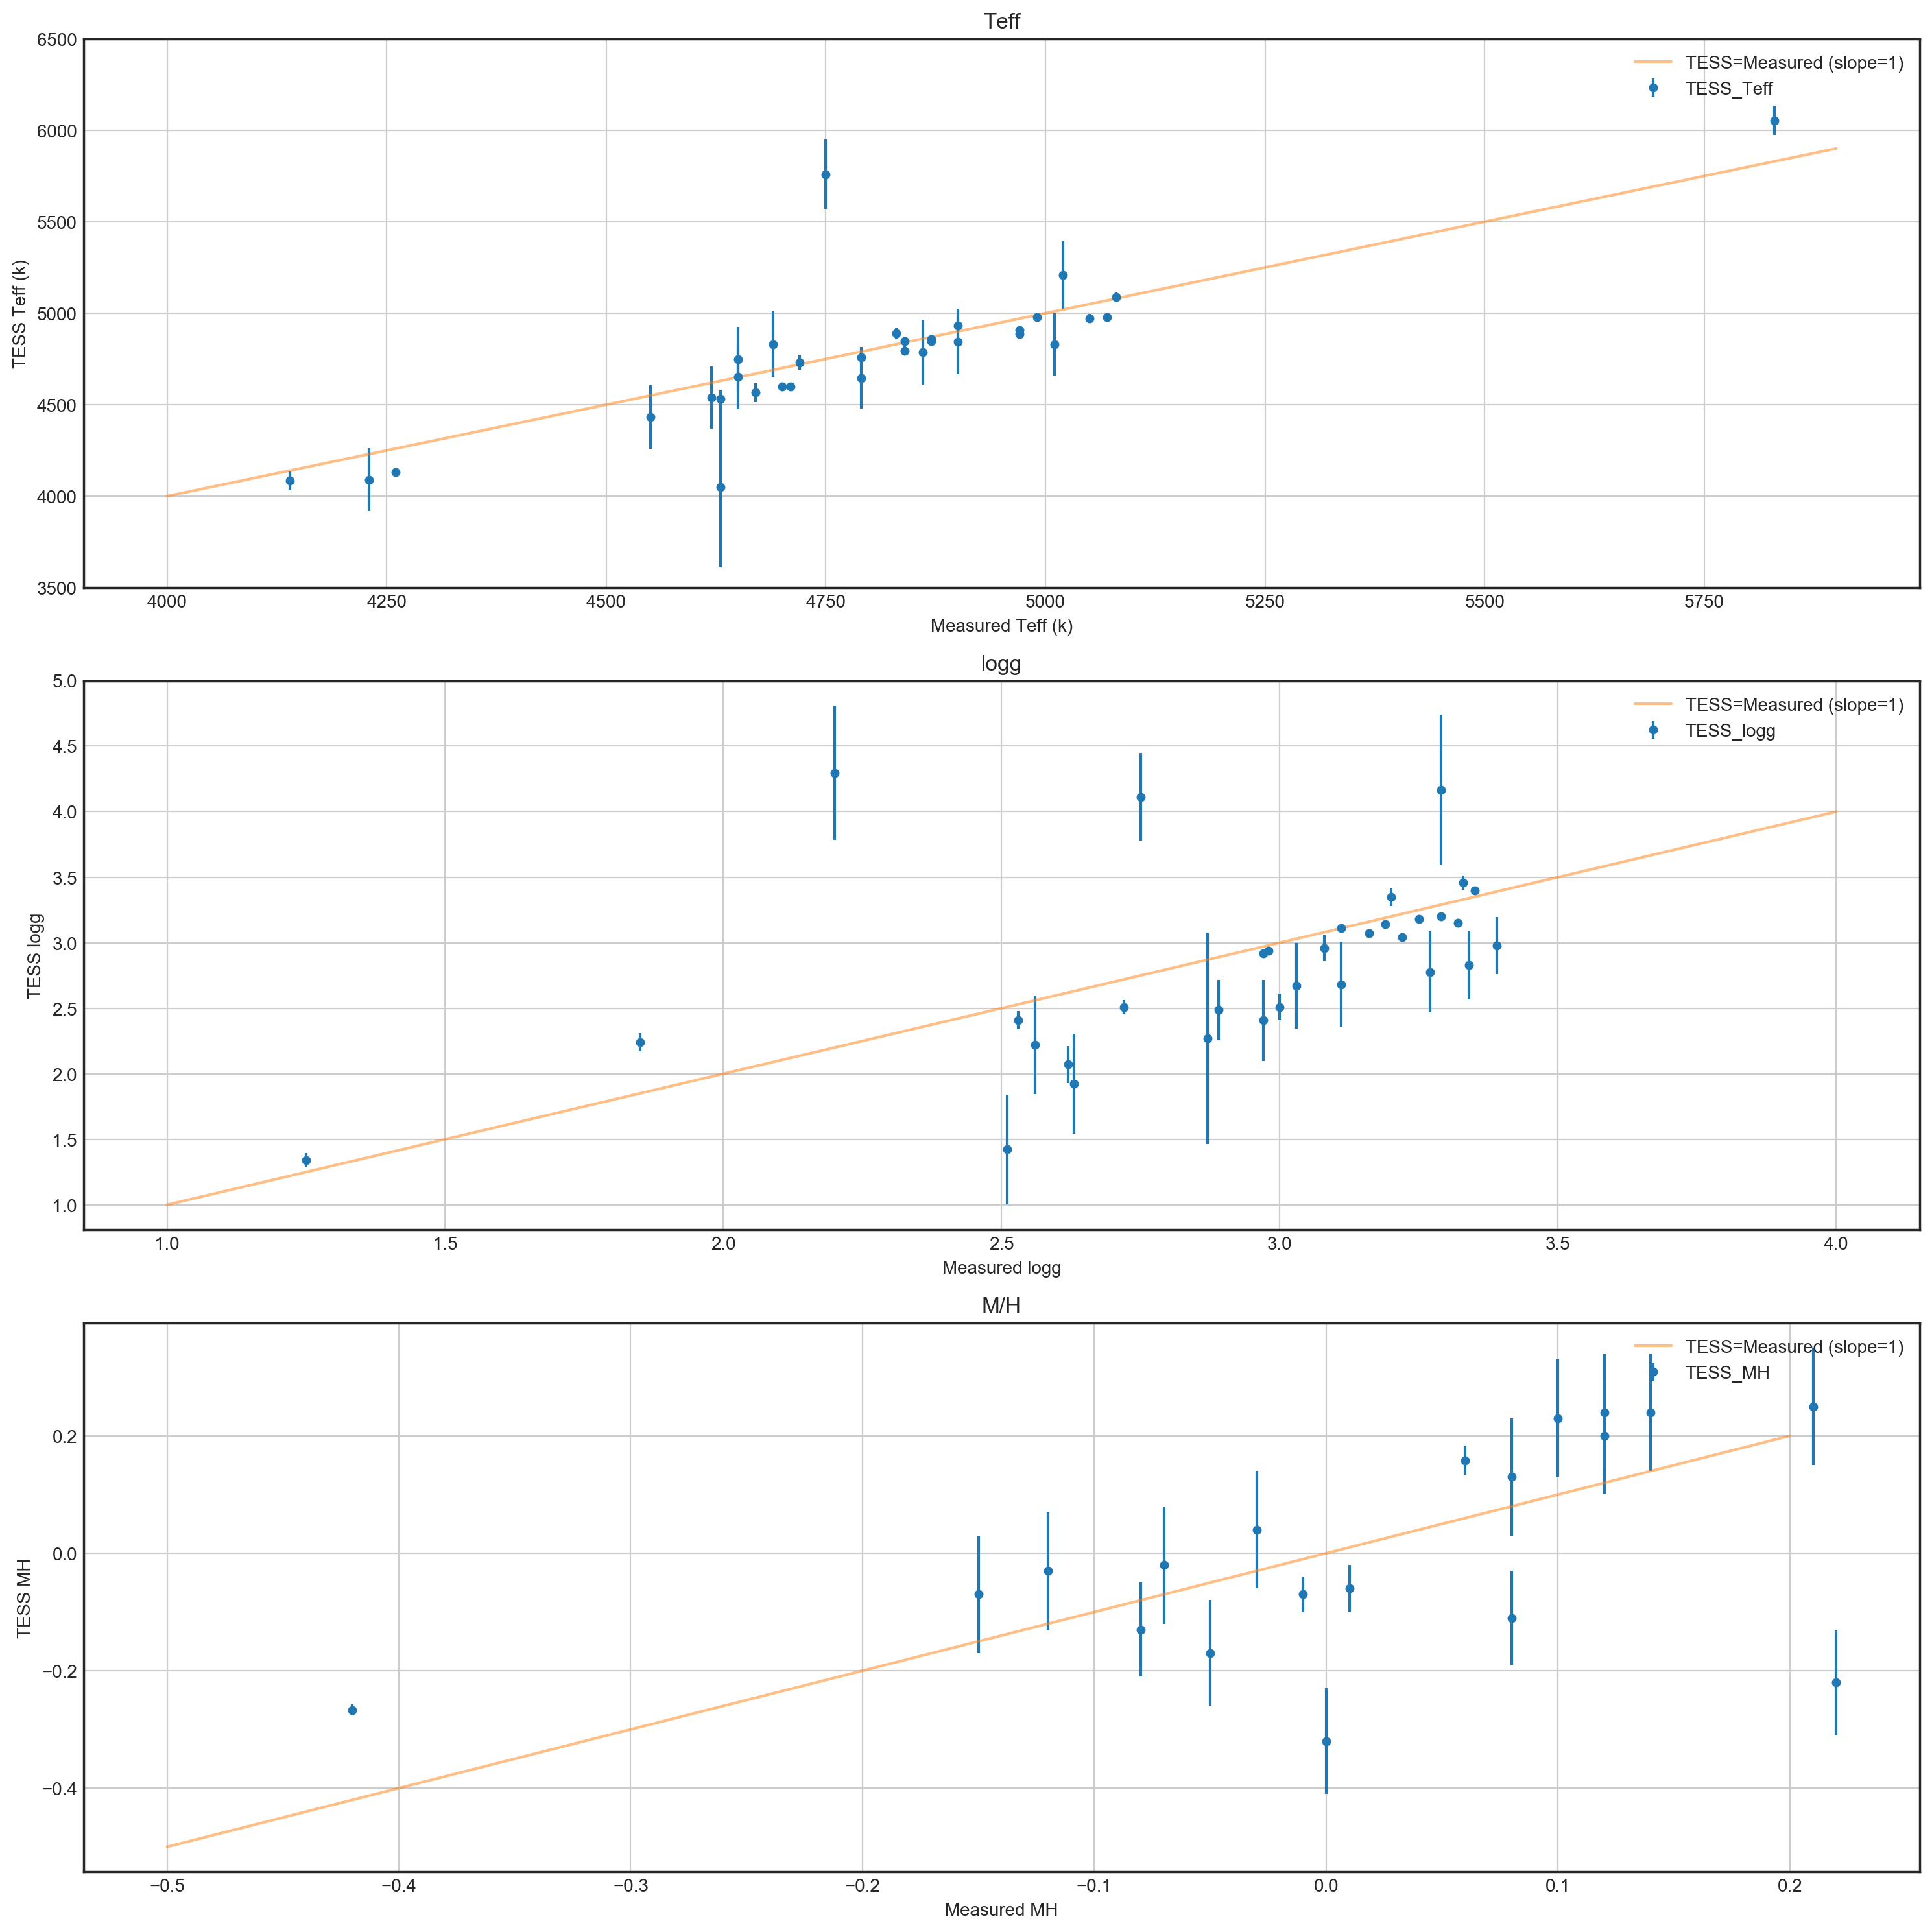

In [190]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,15), dpi = 200)


ax1.errorbar(teff_df['meas_Teff'], teff_df['TESS_Teff'],teff_df['TESS_e_Teff'],fmt='.', markersize=8)
ax1.set_title("Teff")
ax1.set_ylabel("TESS Teff (k)")
ax1.set_xlabel("Measured Teff (k)")
ax1.set_ylim(3500,6500)
x = np.arange(4000, 6000, 100)
y = x
ax1.plot(x,y, alpha=0.5, label="TESS=Measured (slope=1)")
ax1.grid()
ax1.legend()

ax2.errorbar(logg_df['meas_logg'], logg_df['TESS_logg'],logg_df['TESS_e_logg'],fmt='.', markersize=8)
ax2.set_title("logg")
ax2.set_ylabel("TESS logg")
ax2.set_xlabel("Measured logg")
x = np.arange(1., 4.1, 1.)
y = x
ax2.plot(x,y, alpha=0.5, label="TESS=Measured (slope=1)")
ax2.grid()
ax2.legend()

ax3.errorbar(MH_df['meas_MH'], MH_df['TESS_MH'],MH_df['TESS_e_MH'],fmt='.', markersize=8)
ax3.set_title("M/H")
ax3.set_ylabel("TESS MH")
ax3.set_xlabel("Measured MH")
x = np.arange(-0.5, 0.3, 0.1)
y = x
ax3.plot(x,y, alpha=0.5, label="TESS=Measured (slope=1)")
ax3.grid()
ax3.legend()

plt.tight_layout()

#HD 39079 and HD 96036 are A type stars? Way too hot, maybe biting on the wrong stars here from the IDs?

In [146]:
teff_df

,TIC,meas_Teff,TESS_Teff,TESS_e_Teff,meas_logg,TESS_logg,TESS_e_logg,meas_MH,TESS_MH,TESS_e_MH
HD115202,422432907,4830.0,4889,30,3.20,3.35,0.07,0.01,-0.06,0.04
HD118082,659967,4840.0,4846,25,3.19,3.14,0.028,0.08,0.13,0.1
HD123239,385436191,4840.0,4794,25,2.98,2.94,0.028,-0.15,-0.07,0.1
HD125217,46096202,4870.0,4858,25,3.29,3.2,0.028,0.12,0.2,0.1
HD126105,422566985,4900.0,4844,179,3.39,2.97665,0.21678,0.08,--,--
HD188105,321384057,4700.0,4598,15,2.72,2.51,0.05,0.08,-0.11,0.08
HD19138,365301667,4230.0,4090,171,1.75,--,--,-0.38,--,--
HD19810,9804284,4860.0,4786,178,3.27,2.7769,0.310492,-0.07,--,--
HD198599,23862564,5020.0,5209,183,2.97,2.40686,0.309985,-0.05,--,--
HD203638,99636229,4630.0,4532.5,49,2.62,2.07,0.14,0.22,-0.22,0.09
